In [13]:
# Import Libraries
import pandas as pd
import spacy
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [14]:
!pip install emoji
from emoji import demojize

In [15]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [16]:
!pip install langdetect
import nltk
nltk.download('stopwords')
from langdetect import detect, LangDetectException

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
!pip install googletrans
from googletrans import Translator

In [18]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

In [19]:
# Load spaCy model with sentencizer
nlp = spacy.load("en_core_web_sm")
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")
print("spaCy pipeline:", nlp.pipe_names)

spaCy pipeline: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'sentencizer']


In [20]:
def load_data():
    """Load the dataset (100 rows hardcoded here; replace with CSV for 5,000 rows)."""

    data = pd.read_csv('airtel_playstore_reviews.csv')

    data = pd.DataFrame(data)
    print("Data loaded successfully.")
    return data

In [21]:
    data = load_data()
    print("Data loaded successfully.")

Data loaded successfully.
Data loaded successfully.


In [22]:
!pip install https://github.com/explosion/spacy-models/releases/download/xx_ent_wiki_sm-3.6.0/xx_ent_wiki_sm-3.6.0-py3-none-any.whl
# Piece 2: Initialize Tools
# nlp = spacy.load("xx_ent_wiki_sm", disable=["ner"])
# translator = Translator()
# analyzer = SentimentIntensityAnalyzer()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.4/917.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 62.5 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.2
    Uninstalling typer-0.15.2:
      Successfully uninstalled typer-0.15.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalled smart-open-7.1.0
  Attempting uninstall: blis
    Found existing installation: blis 1.2.0
    Uninstalling blis-1.2.0:
      Successfully uninstal

In [23]:
nlp = spacy.load("xx_ent_wiki_sm")  # Load the model
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")  # Add the sentencizer if it's not there
translator = Translator()
analyzer = SentimentIntensityAnalyzer()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'xx_ent_wiki_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [24]:
nlp = spacy.load("xx_ent_wiki_sm")  # Load the model
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")  # Add the sentencizer if it's not there
translator = Translator()
analyzer = SentimentIntensityAnalyzer()

In [25]:
# Piece 3: Preprocess Text
def preprocess_text(text):
    """Clean text, translate non-English, and extract locations."""
    # Keep emojis for language detection
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "en"  # Default to English if detection fails
    text = demojize(text)
    text = re.sub(r'[^\w\s:.!?]', '', text)

    if lang != "en":
        try:
            text = translator.translate(text, dest="en").text
        except Exception as e:
            print(f"Translation error: {e}")
            pass
    location = re.search(r'in\s+([A-Za-z\s]+)', text, re.IGNORECASE)
    location = location.group(1).strip() if location else None
    return text.lower(), location

In [26]:
# Piece 4: Add Time Weight
def add_time_weight(df):
    """Calculate time weight based on days from March 15, 2025."""
    # Updated format string to include seconds
    df["at"] = pd.to_datetime(df["at"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
    df["time_weight"] = df["at"].apply(lambda x: (pd.Timestamp("2025-03-15") - x).days / 30.0)
    return df

In [27]:
# Piece 5: Define Aspects
aspect_keywords = {
    "App Usability": ["app", "ui", "update", "login", "crash", "interface", "open", "work", "useful", "theme", "navigate"],
    "Network Quality": ["network", "signal", "internet", "speed", "coverage", "call", "data", "connection", "4g", "sim"],
    "Customer Service": ["customer", "support", "care", "resolve", "complaint", "service"],
    "Balance/Recharge": ["balance", "recharge", "plan", "otp", "pack"],
    "Features": ["tunes", "ott", "volte", "fiber", "feature", "ringtones", "chat", "tv"]
}
FUZZY_THRESHOLD = 80

In [28]:
# Piece 6: Extract Aspects
def extract_aspects(text):
    """Identify aspects using fuzzy matching."""
    doc = nlp(text)
    aspects = set()
    for token in doc:
        token_text = token.text.lower()
        for aspect, keywords in aspect_keywords.items():
            if any(fuzz.ratio(token_text, keyword) > FUZZY_THRESHOLD or keyword in token_text for keyword in keywords):
                aspects.add(aspect)
    return list(aspects) if aspects else ["General"]

In [29]:
# Piece 7: Get Sentiment
def get_sentiment(text, score):
    """Calculate sentiment with negation and score adjustment."""
    scores = analyzer.polarity_scores(text)
    compound = scores["compound"]
    if any(word in text.lower() for word in ["not", "nahi", "no", "never", "cant", "wont"]):
        compound = -compound
    if compound >= 0.05:
        sentiment = "Positive"
    elif compound <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    original_sentiment = sentiment
    if score <= 2 and sentiment == "Positive":
        sentiment = "Negative"
    elif score >= 4 and sentiment == "Negative":
        sentiment = "Positive"
    return sentiment, original_sentiment != sentiment

In [30]:
# Piece 8: Analyze Aspect Sentiments
def analyze_aspect_sentiments(text, aspects, score, reply):
    """Assign sentiments to aspects, handling sparsity and replies."""
    sentences = [sent.text.strip() for sent in nlp(text).sents]
    aspect_sentiments = {}
    for sent in sentences:
        for aspect in aspects:
            if any(fuzz.ratio(sent.lower(), keyword) > FUZZY_THRESHOLD or keyword in sent.lower() for keyword in aspect_keywords.get(aspect, [""])):
                sentiment, mismatched = get_sentiment(sent, score)
                aspect_sentiments[aspect] = sentiment
                break
    if not aspect_sentiments and aspects == ["General"]:
        sentiment, mismatched = get_sentiment(text, score)
        aspect_sentiments["General"] = sentiment
    if isinstance(reply, str) and reply and any(word in reply.lower() for word in ["fixed", "resolved", "assist"]):
        for aspect in aspect_sentiments:
            if aspect_sentiments[aspect] == "Negative":
                aspect_sentiments[aspect] = "Neutral"
    return aspect_sentiments

In [31]:
# Piece 9: Aggregate Sentiments
def aggregate_sentiments(df):
    """Aggregate sentiments with time weighting and version grouping."""
    aspect_counts = defaultdict(lambda: {"Positive": 0, "Negative": 0, "Neutral": 0, "Weighted": 0})
    for _, row in df.iterrows():
        weight = row["time_weight"]
        for aspect, sentiment in row["aspect_sentiments"].items():
            aspect_counts[aspect][sentiment] += 1
            aspect_counts[aspect]["Weighted"] += weight if sentiment in ["Positive", "Negative"] else weight * 0.5
    result_df = pd.DataFrame.from_dict(aspect_counts, orient="index").fillna(0)
    result_df["Total Mentions"] = result_df["Positive"] + result_df["Negative"] + result_df["Neutral"]
    for sentiment in ["Positive", "Negative", "Neutral"]:
        result_df[f"{sentiment} %"] = (result_df[sentiment] / result_df["Total Mentions"] * 100).round(2)

    version_groups = df.groupby("appVersion").apply(lambda x: defaultdict(lambda: {"Positive": 0, "Negative": 0, "Neutral": 0}))
    for version, group in df.groupby("appVersion"):
        for _, row in group.iterrows():
            for aspect, sentiment in row["aspect_sentiments"].items():
                version_groups[version][aspect][sentiment] += 1
    return result_df, version_groups

In [32]:
# Piece 10: Detect Emerging Aspects
def detect_emerging_aspects(df):
    """Cluster text to find new aspects."""
    vectorizer = TfidfVectorizer(max_features=100, stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(df["content_processed"])
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    df["cluster"] = clusters
    emerging_aspects = vectorizer.get_feature_names_out()[kmeans.cluster_centers_.argsort()[:, -5:]].tolist()
    return [term for sublist in emerging_aspects for term in sublist if term not in sum(aspect_keywords.values(), [])], df

In [33]:
# Piece 11: Visualize Results
def visualize_results(result_df):
    """Generate a stacked bar chart."""
    result_df[["Positive", "Negative", "Neutral"]].plot(kind="bar", stacked=True, figsize=(10, 6))
    plt.title("Aspect-Based Sentiment Analysis")
    plt.xlabel("Aspects")
    plt.ylabel("Count")
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.savefig("aspect_sentiment_plot.png")
    plt.show()

Data loaded successfully.
Data loaded successfully.
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'


<ipython-input-25-b22b2f3ac53f>:17: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  pass


Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translation error: 'coroutine' object has no attribute 'text'
Translat

<ipython-input-31-d69cdbe6d92c>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  version_groups = df.groupby("appVersion").apply(lambda x: defaultdict(lambda: {"Positive": 0, "Negative": 0, "Neutral": 0}))



Aggregated Sentiment Table (Normalized):
                  Positive  Negative  Neutral  Total Mentions  Positive %  Negative %  Neutral %     Weighted
App Usability          827       508      910            2245       36.84       22.63      40.53  3982.700000
General               2704       434     1023            4161       64.98       10.43      24.59  8195.716667
Customer Service       401       741      287            1429       28.06       51.85      20.08  2869.966667
Features                67        71       88             226       29.65       31.42      38.94   385.733333
Network Quality        475       904      749            2128       22.32       42.48      35.20  4058.100000
Balance/Recharge        75        85      254             414       18.12       20.53      61.35   642.366667

Emerging Aspects from Clustering:
['bad', 'nice', 'bsnl', 'getting', 'time', 'bsnl', 'best', 'working', 'bsnl', 'good', 'worst', 'bsnl', 'nice', 'good']
Results saved to CSV.


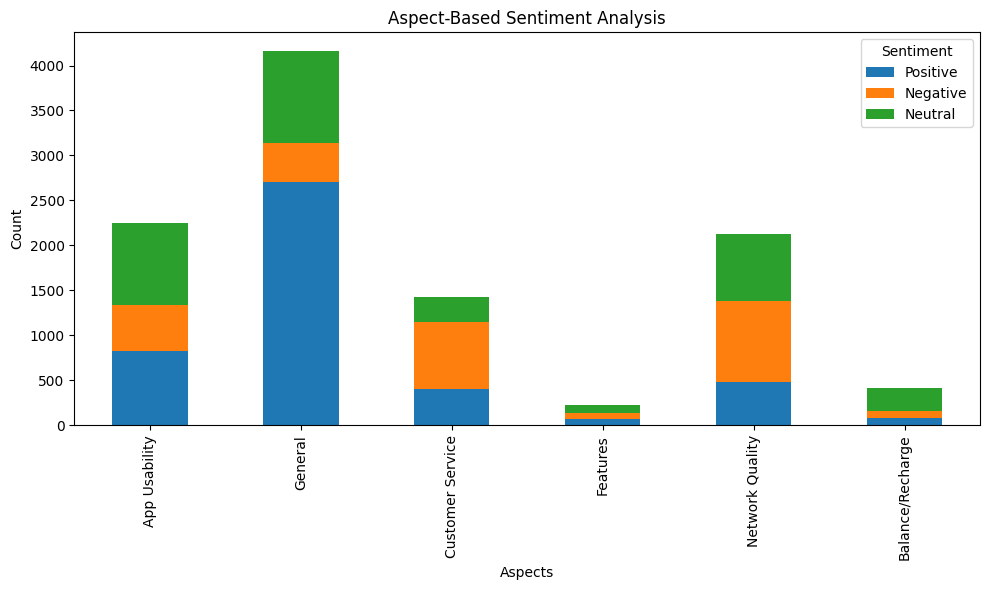

Visualization completed.


In [34]:
# Main Execution
if __name__ == "__main__":
    # Load data
    data = load_data()
    print("Data loaded successfully.")

    # Preprocess text
    data[["content_processed", "location"]] = pd.DataFrame(data["content"].apply(preprocess_text).tolist(), index=data.index)
    print("Text preprocessing completed.")

    # Add time weight
    data = add_time_weight(data)
    print("Time weights added.")

    # Extract aspects
    data["aspects"] = data["content_processed"].apply(extract_aspects)
    print("Aspects extracted.")

    # Analyze sentiments
    data["aspect_sentiments"] = data.apply(lambda row: analyze_aspect_sentiments(row["content_processed"], row["aspects"], row["score"], row["replyContent"]), axis=1)
    print("Sentiments analyzed.")

    # Aggregate sentiments
    result_df, version_groups = aggregate_sentiments(data)
    print("\nAggregated Sentiment Table (Normalized):")
    print(result_df[["Positive", "Negative", "Neutral", "Total Mentions", "Positive %", "Negative %", "Neutral %", "Weighted"]].to_string(index=True))

    # Detect emerging aspects
    emerging_aspects, data = detect_emerging_aspects(data)
    print("\nEmerging Aspects from Clustering:")
    print(emerging_aspects)

    # Save results
    result_df.to_csv("aspect_sentiment_summary.csv")
    print("Results saved to CSV.")

    # Visualize
    visualize_results(result_df)
    print("Visualization completed.")